In [1]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os

print(f"tensorflow: {tf.__version__}")
print(f"keras: {tf.keras.__version__}")

tensorflow: 2.0.0-beta1
keras: 2.2.4-tf


In [3]:
data_dir = "data/GSE92742_Broad_LINCS"
out_dir = "data/output"

fnames = [
    "Level3_INF_mlr12k_n1319138x12328.gctx",
    "gene_info_delta_landmark.txt",
    "inst_info.txt",
    "pert_info.txt",
    "cell_info.txt",
]

fpaths = {
    "_".join(f.split(".")[0].split('_')[:2]): f"{data_dir}/{f}" for f in fnames
}

### Step 1: Load data and extract untreated samples for DE analysis
#### Load data
Extract all samples for training model (VCAP, MCF7, PC3), but filter for untreated and save for DE analysis in R.

In [4]:
from lib.utils import load_data

pert_types = [
    "trt_cp",  # treated with compound
    "ctl_vehicle",  # control for compound treatment (e.g DMSO)
    "ctl_untrt",  # untreated samples
]

cell_ids = ["VCAP", "MCF7", "PC3"]  # prostate tumor  # breast tumor  # prostate tumor

# Load Data
dset = load_data(
    fpaths["Level3_INF"], fpaths["inst_info"], fpaths["gene_info"], pert_types, cell_ids
)

dset

<LINCS Dataset: (samples: 333,523, genes: 978)>

#### Sample controls and save to disk 
Extract the control samples for DE.

In [5]:
ctrl_data = dset.filter_rows(pert_type=["ctl_vehicle", "ctl_untrt"])
ctrl_data.sample_rows(meta_groups="cell_id", size=100).to_tsv(out_dir, name='control')

#### Create model


In [6]:
from lib.models import create_AE

tf.random.set_seed(42)
np.random.seed(42)

dset.normalize_by_gene()
dset.train_val_test_split()

print(f"training size:   {dset.train}")
print(f"validation size: {dset.val}")
print(f"testing size:    {dset.test}")

training size:   <LINCS Dataset: (samples: 213,454, genes: 978)>
validation size: <LINCS Dataset: (samples: 53,364, genes: 978)>
testing size:    <LINCS Dataset: (samples: 66,705, genes: 978)>


In [7]:
h_size = 32
model = create_AE([128, h_size, 128], dropout=0.2)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               125312    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 978)               1

#### Train Model

In [8]:
batch_size = 64
model.fit(
    dset.train.to_tf_dataset(target="self", batch_size=batch_size),
    epochs=10,
    shuffle=True,
    steps_per_epoch=dset.train.data.shape[0] // batch_size,
    validation_data=(dset.val.data.values, dset.val.data.values),
#     verbose=False,
)

W0705 15:08:22.016494 139634595366720 deprecation.py:323] From /Users/manz01/miniconda3/envs/lincs-gpu/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
3335/3335 [==============================] - 15s 4ms/step - loss: 0.0091 - cosine_similarity: 0.9887 - pearsons_corrcoef: 0.8600 - val_loss: 0.0059 - val_cosine_similarity: 0.9922 - val_pearsons_corrcoef: 0.8946
Epoch 2/10
3335/3335 [==============================] - 12s 4ms/step - loss: 0.0057 - cosine_similarity: 0.9924 - pearsons_corrcoef: 0.8885 - val_loss: 0.0049 - val_cosine_similarity: 0.9935 - val_pearsons_corrcoef: 0.9148
Epoch 3/10
3335/3335 [==============================] - 13s 4ms/step - loss: 0.0052 - cosine_similarity: 0.9930 - pearsons_corrcoef: 0.9091 - val_loss: 0.0049 - val_cosine_similarity: 0.9935 - val_pearsons_corrcoef: 0.9152
Epoch 4/10
3335/3335 [==============================] - 12s 4ms/step - loss: 0.0050 - cosine_similarity: 0.9932 - pearsons_corrcoef: 0.9057 - val_loss: 0.0050 - val_cosine_similarity: 0.9933 - val_pearsons_corrcoef: 0.9129
Epoch 5/10
3335/3335 [==============================] - 12s 4ms/step - loss: 0.0049 - cosine_similarity: 0.9

In [9]:
test_loss = model.evaluate(dset.test.data.values, dset.test.data.values)
print(f"loss: {test_loss}")

66705/66705 [==============================] - 3s 41us/sample - loss: 0.0050 - cosine_similarity: 0.9933 - pearsons_corrcoef: 0.9013
loss: [0.004971037399524721, 0.99333483, 0.90132356]


#### Examine hidden output for control samples

In [10]:
from lib.utils import get_hidden_activations
# Extract control samples from testing data
test_ctrl_data = dset.test.filter_rows(pert_type=["ctl_vehicle", "ctl_untrt"])

encoder = tf.keras.Model(inputs=model.layers[0].input, outputs=model.layers[2].output)
hidden_output = get_hidden_activations(test_ctrl_data.data, encoder)
hidden_output.head()

,unit_0,unit_1,unit_2,unit_3,unit_4,unit_5,unit_6,unit_7,unit_8,unit_9,...,unit_22,unit_23,unit_24,unit_25,unit_26,unit_27,unit_28,unit_29,unit_30,unit_31
inst_id,,,,,,,,,,,,,,,,,,,,,
KDB002_MCF7_96H_X3_B1_DUO53HI52LO:F16,0.018937,0.0,0.0,0.0000,0.213459,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.312942,0.000000,0.281580,0.0,0.0,0.0,0.196818
DOS032_MCF7_24H_X1_F2B4_DUO52HI53LO:F10,0.000000,0.0,0.0,0.0000,0.000000,0.087059,0.0,0.000000,0.290822,0.353728,...,0.0,0.181587,0.000000,0.000000,0.000000,0.173687,0.0,0.0,0.0,0.165839
ERGK006_VCAP_120H_X3_B2_DUO52HI53LO:G20,0.000000,0.0,0.0,0.1603,0.000000,0.000000,0.0,0.706672,0.000000,0.000000,...,0.0,0.000000,0.121469,0.118697,0.000000,0.000000,0.0,0.0,0.0,0.000000
CPD002_MCF7_6H_X3_B6_DUO52HI53LO:F05,0.067945,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.352668,0.107643,...,0.0,0.000000,0.000000,0.000000,0.000000,0.242336,0.0,0.0,0.0,0.097257
KDA009_MCF7_96H_X2_B1_DUO45HI44LO:N13,0.334460,0.0,0.0,0.0000,0.684149,0.299258,0.0,0.000000,0.000000,0.000000,...,0.0,0.079368,0.000000,0.651137,0.037286,0.381762,0.0,0.0,0.0,0.221394


### Extract only the active hidden units

In [11]:
from lib.plotting import plot_clustermap
# plot_clustermap(hidden_output, test_ctrl_data.sample_meta, "cell_id")

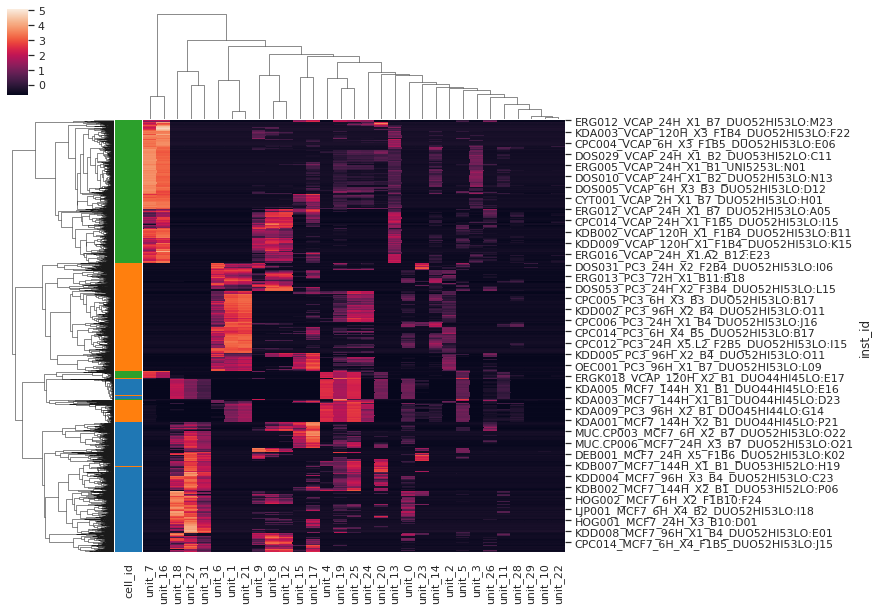

In [12]:
def get_active_units(hidden_output, thresh=0.001):
    # find units where sum of activation across all samples is in total >= tresh
    mask = hidden_output.sum(axis=0) >= thresh
    return hidden_output.loc[:,mask]

active_hidden_units = get_active_units(hidden_output)
plot_clustermap(active_hidden_units, test_ctrl_data.sample_meta, "cell_id")

#### Find 100 the most activating in each unit

In [13]:
from lib.utils import get_most_activating_ids

# Find the most activating samples for each unit
most_activating_ids = get_most_activating_ids(hidden_output, size=100)

# Lookup the most activating samples by id
most_activating_samples = {
    unit: dset.lookup_samples(ids).data for unit, ids in most_activating_ids.items()
}

# Write most activating samples to disk for DE analysis
for unit, df in most_activating_samples.items():
    df.to_csv(f"data/activating_units/{unit}_most_activating.csv")

### Zero-out method

In [14]:
from lib.zero_out import zero_out_method
from lib.utils import embed_hidden_output
from lib.plotting import plot_embedding
import altair as alt

In [ ]:
zeroed_rank = zero_out_method(encoder, test_ctrl_data)
zeroed_rank.head()

In [ ]:
count_freq = (
    zeroed_rank.join(dset.sample_meta)  # add metadata for each sample
    .groupby(["cell_id", "unit", "gene_id"])
    .size()  # count the frequency of each gene_id for each unit for each cell id
    .reset_index(name="freq")
)
count_freq.head()

In [ ]:
embedding_type = "umap"
embeded = embed_hidden_output(active_hidden_units, type_=embedding_type)

In [ ]:
gene_count_freq = pd.merge(
    count_freq,
    pd.read_csv(fpaths["gene_info"], sep="\t"),
    left_on="gene_id",
    right_on="pr_gene_id",
)

# selections
selection = alt.selection_single(fields=["cell_id"])
pts = alt.selection_multi(fields=["pert_id"])
base = alt.Chart(embeded.join(dset.test.sample_meta).reset_index())

scatter = (
    base
    .mark_circle()
    .encode(
        x=f"{embedding_type}_1:Q",
        y=f"{embedding_type}_2:Q",
        color=alt.condition(pts, alt.Color("cell_id:N"), alt.value("lightgray")),
    )
    .add_selection(selection)
    .properties(height=300, width=400)
)


pert_info_bar = (
    base.mark_bar()
    .encode(
        x="count()",
        y=alt.Y(
            "pert_id:N",
            sort=alt.EncodingSortField(field="pert_id", op="count", order="descending"),
            axis=alt.Axis(orient=alt.AxisOrient("right")),
        ),
        color=alt.condition(pts, alt.ColorValue("grey"), alt.ColorValue("lightgrey")),
    )
    .properties(height=300, width=400)
    .add_selection(pts)
)

barplot = (
    alt.Chart(gene_count_freq)
    .transform_filter(selection)
    .transform_filter(alt.datum.freq > 50)
    .transform_calculate(url="https://www.ncbi.nlm.nih.gov/gene/" + alt.datum.gene_id)
    .mark_bar()
    .encode(
        x=alt.X(
            "pr_gene_symbol:N",
            sort=alt.EncodingSortField(field="freq", order="descending"),
        ),
        y="freq:Q",
        color="cell_id:N",
        href="url:N",
        tooltip=["gene_id:N", "pr_gene_symbol:N", "freq:Q"],
    )
    .properties(height=50, width=850)
    .facet(row="unit")
)

barplot & (scatter | pert_info_bar)